In [1]:
from pathlib import Path
import sys  
import os
import pandas as pd 
from datetime import datetime
import scipy.sparse as sps
from numpy import linalg as LA
from tqdm import tqdm

import numpy as np
from operator import itemgetter

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "libs")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from Utils.load_URM import load_URM
from Utils.load_ICM import load_ICM

from scipy.sparse import hstack, vstack
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_all = load_URM("../data/data_train.csv")
ICM_all = load_ICM("../data/data_ICM_metadata.csv")

In [5]:
from libs.Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender 
from libs.Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from libs.Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from libs.Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

In [6]:
import optuna as op
from xgboost import XGBRanker
from xgboost import plot_importance

In [7]:
def create_dataframe_with_label(URM_features,URM_label,other_algorithms,cutoff):
    n_users_features, n_items_features = URM_features.shape
    training_dataframe = pd.DataFrame(index=range(0,n_users_features), columns = ["ItemID"])
    training_dataframe.index.name='UserID'
    #print(training_dataframe.columns)

    for user_id in range(n_users_features):    
        recommendations = other_algorithms["candidate_generator"].recommend(user_id, cutoff = cutoff)
        training_dataframe.loc[user_id, "ItemID"] = recommendations
        
    #print(training_dataframe.columns)
    training_dataframe = training_dataframe.explode("ItemID")

    URM_label_coo = sps.coo_matrix(URM_label)

    correct_recommendations = pd.DataFrame({"UserID": URM_label_coo.row,
                                        "ItemID": URM_label_coo.col})

    training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
    training_dataframe["Label"] = training_dataframe["Exist"] == "both"
    training_dataframe.drop(columns = ['Exist'], inplace=True)
    
    training_dataframe = training_dataframe.set_index('UserID')

    for user_id in range(n_users_features):  
        for rec_label, rec_instance in other_algorithms.items():
            if rec_label!= "candidate_generator":
                item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
                all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

                training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

    training_dataframe = training_dataframe.reset_index()
    training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
    
    item_popularity = np.ediff1d(sps.csc_matrix(URM_features).indptr)

    training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
    
    user_popularity = np.ediff1d(sps.csr_matrix(URM_features).indptr)

    training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
    
    training_dataframe = training_dataframe.sort_values("UserID").reset_index()
    training_dataframe.drop(columns = ['index'], inplace=True)
    
    return training_dataframe

In [8]:
def create_dataframe_without_label(URM_features,other_algorithms,cutoff):
    n_users_features, n_items_features = URM_features.shape
    training_dataframe = pd.DataFrame(index=range(0,n_users_features), columns = ["ItemID"])
    training_dataframe.index.name='UserID'
    #print(training_dataframe.columns)
    #print(training_dataframe)
    
    for user_id in range(n_users_features):    
        recommendations = other_algorithms["candidate_generator"].recommend(user_id, cutoff = cutoff)
        training_dataframe.loc[user_id, "ItemID"] = recommendations
        
    #print(training_dataframe.columns)
    #print(training_dataframe)
    training_dataframe = training_dataframe.explode("ItemID")
    #training_dataframe = training_dataframe.set_index('UserID')

    for user_id in range(n_users_features):  
        for rec_label, rec_instance in other_algorithms.items():
            if rec_label!= "candidate_generator":
                item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
                all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

                training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

    training_dataframe = training_dataframe.reset_index()
    training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
    
    item_popularity = np.ediff1d(sps.csc_matrix(URM_features).indptr)

    training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
    
    user_popularity = np.ediff1d(sps.csr_matrix(URM_features).indptr)

    training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
    
    training_dataframe = training_dataframe.sort_values("UserID").reset_index()
    training_dataframe.drop(columns = ['index'], inplace=True)
    
    return training_dataframe

In [9]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

In [10]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=10):
    
    #cumulative_precision = 0.0
    #cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, cutoff=at)
            num_eval+=1

            #cumulative_precision += precision(recommended_items, relevant_items)
            #cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    #cumulative_precision /= num_eval
    #cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    return MAP

def evaluate_algorithm_xgboost(URM_test, dataframe_to_evaluate, model):
    
    cumulative_AP = 0.0
    
    num_eval = 0

    # we look for all the users 
    for user_id in tqdm(range(URM_test.shape[0])):
        
        # we get the relevant items for this user
        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        # if the user have something in the test data we evaluate it
        if len(relevant_items)>0:
            
            X_to_predict = dataframe_to_evaluate[dataframe_to_evaluate["UserID"] == user_id].copy()

            preds = model.predict(X_to_predict)
            X_to_predict["rank"] = preds
            X_to_predict = X_to_predict.sort_values(by = "rank", ascending = False)
            recommended_items = np.array(X_to_predict["ItemID"])[:10]
            
            num_eval+=1

            cumulative_AP += AP(recommended_items, relevant_items)
            
    MAP = cumulative_AP / num_eval
    
    return MAP

In [11]:
URM_train = sps.load_npz("URM_train_ens.npz")
URM_val = sps.load_npz("URM_val_ens.npz")
URM_test = sps.load_npz("URM_test_ens.npz")

URM_train_val = sps.load_npz("URM_train_val_ens.npz")
#URM_train1, URM_train2 = split_train_in_two_percentage_global_sample(URM_train,train_percentage=0.85)
URM_train1 = sps.load_npz("URM_train1.npz")
URM_train2 = sps.load_npz("URM_train2.npz")

In [12]:
print(f"Train size: {URM_train.getnnz()}, Train1 size: {URM_train1.getnnz()}, Train2 size: {URM_train2.getnnz()}, Val size: {URM_val.getnnz()}, Test size: {URM_test.getnnz()}")

Train size: 1274929, Train1 size: 1083690, Train2 size: 191239, Val size: 224987, Test size: 264691


In [13]:
evaluator_val = EvaluatorHoldout(URM_val, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1008 ( 2.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 527 ( 1.5%) Users that have less than 1 test interactions


In [14]:
# sps.save_npz('URM_train1.npz', URM_train1)
# sps.save_npz('URM_train2.npz', URM_train2)

In [15]:
SLIM_ElasticRecall_train1 = SLIMElasticNetRecommender(URM_train1)
#SLIM_ElasticRecall_train1.fit(topK= 296, l1_ratio=0.10442943478590742, alpha=0.00035921608889258387)
SLIM_ElasticRecall_train1.load_model("result_experiments/SLIM/", "SLIM_ElasticRecall_train1")

#SLIM_ElasticRecall_train1.fit(l1_ratio=0.11006885790633625, alpha=0.0002551115306127753, topK = 307)

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_ElasticRecall_train1'
SLIMElasticNetRecommender: Loading complete


In [16]:
#SLIM_ElasticRecall_train1.save_model("result_experiments/SLIM/", "SLIM_ElasticRecall_train1")

In [17]:
rp3_res = pd.read_csv("result_experiments/RP3beta/results_optuna_recall.csv")

In [18]:
rp3_res.sort_values('RECALL', ascending=False)

,topK,alpha,beta,normalize_similarity,implicit,iteration,RECALL,MAP
215,17,0.205870,0.243986,True,False,215,0.121592,0.028174
292,15,0.226711,0.242385,True,False,292,0.121557,0.028222
131,15,0.241819,0.231215,True,False,131,0.121533,0.028219
132,16,0.215236,0.211150,True,False,132,0.121484,0.028252
155,15,0.219787,0.244360,True,False,155,0.121469,0.028225
...,...,...,...,...,...,...,...,...
105,2,0.217050,0.145436,True,False,105,0.086316,0.019439
6,3,0.741872,0.601899,True,False,6,0.086161,0.020446
28,2,0.860130,0.472470,True,True,28,0.079526,0.018267
10,118,0.873202,0.894319,True,False,10,0.074295,0.015692


In [19]:
RP3BetaRecall_train1 = RP3betaRecommender(URM_train1)
#RP3BetaRecall_train1.fit(alpha=0.205870, beta=0.243986, topK=17, min_rating=0.0, implicit=False, normalize_similarity=True)
RP3BetaRecall_train1.load_model("result_experiments/RP3beta/", "RP3BetaRecall_train1")

RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3BetaRecall_train1'
RP3betaRecommender: Loading complete


In [20]:
# RP3BetaRecall_train1.save_model("result_experiments/RP3beta/", "RP3BetaRecall_train1")

In [21]:
knn_res = pd.read_csv("result_experiments/ItemKNNCFRecommender/results_tversky_optuna_recall.csv")

In [56]:
knn_res.sort_values('RECALL', ascending=False)

,topK,shrink,feature_weighting,normalize,tversky_alpha,tversky_beta,iteration,RECALL,MAP
96,6,21.589349,TF-IDF,False,0.167252,1.722013,96,0.118551,0.028130
220,6,22.217756,none,False,0.227589,1.788536,220,0.118239,0.028126
102,6,21.079349,TF-IDF,False,0.196247,1.733155,102,0.118240,0.028112
83,6,22.622420,TF-IDF,False,0.255611,1.770004,83,0.118308,0.028104
249,6,20.613082,none,False,0.235928,1.767350,249,0.118309,0.028103
...,...,...,...,...,...,...,...,...,...
6,19,18.287544,BM25,True,0.702835,0.703088,6,0.103331,0.023864
5,47,8.640345,BM25,False,0.346342,1.396634,5,0.102509,0.023736
3,42,8.196521,BM25,False,0.173447,0.219287,3,0.099767,0.022978
43,2,22.286228,TF-IDF,False,0.320202,0.102723,43,0.100111,0.022212


In [22]:
KNNRecall_train1 = ItemKNNCFRecommender(URM_train1)
# KNNRecall_train1.fit(similarity='tversky', topK=5, shrink=24.383723,
#                    feature_weighting='none', tversky_alpha=0.405750,
#                    tversky_beta=1.823707,
#                    normalize=True)

KNNRecall_train1.load_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_train1")

ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNNRecall_train1'
ItemKNNCFRecommender: Loading complete


In [70]:
# KNNRecall_train1.save_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_train1")

ItemKNNCFRecommender: Saving model in file 'result_experiments/ItemKNNCFRecommender/KNNRecall_train1'
ItemKNNCFRecommender: Saving complete


In [23]:
new_similarityRecall = 0.7747783599151299 * SLIM_ElasticRecall_train1.W_sparse + 0.10970438576060675 * RP3BetaRecall_train1.W_sparse + 0.1155172543242634 * KNNRecall_train1.W_sparse
candidate_gen_train1 = ItemKNNCustomSimilarityRecommender(URM_train1)
candidate_gen_train1.fit(new_similarityRecall)
#candidate_gen_train1.load_model("result_experiments/ensemble_SLIM_RP3_KNNCFR/", "candidate_gen_train1")

In [71]:
# candidate_gen_train1.save_model("result_experiments/ensemble_SLIM_RP3_KNNCFR/", "candidate_gen_train1")

ItemKNNCustomSimilarityRecommender: Saving model in file 'result_experiments/ensemble_SLIM_RP3_KNNCFR/candidate_gen_train1'
ItemKNNCustomSimilarityRecommender: Saving complete


In [24]:
SLIM_ElasticRecall_eval = SLIMElasticNetRecommender(URM_train)
#SLIM_ElasticRecall_eval.fit(topK= 296, l1_ratio=0.10442943478590742, alpha=0.00035921608889258387)
SLIM_ElasticRecall_eval.load_model("result_experiments/SLIM/", "SLIM_ElasticRecall_eval")

#SLIM_ElasticRecall_eval.load_model('result_experiments/SLIM/', 'slim_320_train_ens')

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_ElasticRecall_eval'
SLIMElasticNetRecommender: Loading complete


In [25]:
# SLIM_ElasticRecall_eval.save_model("result_experiments/SLIM/", "SLIM_ElasticRecall_eval")

In [26]:
RP3BetaRecall_eval = RP3betaRecommender(URM_train)
RP3BetaRecall_eval.load_model("result_experiments/RP3beta/", "RP3BetaRecall_eval")
#RP3BetaRecall_eval.fit(alpha=0.205870, beta=0.243986, topK=17, min_rating=0.0, implicit=False, normalize_similarity=True)

RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3BetaRecall_eval'
RP3betaRecommender: Loading complete


In [27]:
# RP3BetaRecall_eval.save_model("result_experiments/RP3beta/", "RP3BetaRecall_eval")

In [28]:
KNNRecall_eval = ItemKNNCFRecommender(URM_train)
KNNRecall_eval.load_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_eval")
# KNNRecall_eval.fit(similarity='tversky', topK=5, shrink=24.383723,
#                    feature_weighting='none', tversky_alpha=0.405750,
#                    tversky_beta=1.823707,
#                    normalize=True)

ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNNRecall_eval'
ItemKNNCFRecommender: Loading complete


In [74]:
# KNNRecall_eval.save_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_eval")

ItemKNNCFRecommender: Saving model in file 'result_experiments/ItemKNNCFRecommender/KNNRecall_eval'
ItemKNNCFRecommender: Saving complete


In [29]:
new_similarityRecall_eval = 0.7747783599151299 * SLIM_ElasticRecall_eval.W_sparse + 0.10970438576060675 * RP3BetaRecall_eval.W_sparse + 0.1155172543242634 * KNNRecall_eval.W_sparse
candidate_gen_eval = ItemKNNCustomSimilarityRecommender(URM_train)
candidate_gen_eval.fit(new_similarityRecall_eval)

In [36]:
#evaluator_val.evaluateRecommender(candidate_gen_eval)

In [75]:
# candidate_gen_eval.save_model("result_experiments/ensemble_SLIM_RP3_KNNCFR/", "candidate_gen_eval")

ItemKNNCustomSimilarityRecommender: Saving model in file 'result_experiments/ensemble_SLIM_RP3_KNNCFR/candidate_gen_eval'
ItemKNNCustomSimilarityRecommender: Saving complete


In [30]:
SLIM_Elastic_train1 = SLIMElasticNetRecommender(URM_train1)
SLIM_Elastic_train1.load_model("result_experiments/SLIM/", "SLIM_Elastic_train1")
#SLIM_Elastic_train1.fit(topK=320, l1_ratio=0.1527515113685262, alpha=0.00022576119312621578)

SLIM_Elastic_eval = SLIMElasticNetRecommender(URM_train)
SLIM_Elastic_eval.load_model("result_experiments/SLIM/", "SLIM_Elastic_eval")
#SLIM_Elastic_eval.load_model("result_experiments/SLIM/", "slim_320_train_ens")

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_Elastic_train1'
SLIMElasticNetRecommender: Loading complete
SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_Elastic_eval'
SLIMElasticNetRecommender: Loading complete


In [76]:
# SLIM_Elastic_train1.save_model("result_experiments/SLIM/", "SLIM_Elastic_train1")
# SLIM_Elastic_eval.save_model("result_experiments/SLIM/", "SLIM_Elastic_eval")

SLIMElasticNetRecommender: Saving model in file 'result_experiments/SLIM/SLIM_Elastic_train1'
SLIMElasticNetRecommender: Saving complete
SLIMElasticNetRecommender: Saving model in file 'result_experiments/SLIM/SLIM_Elastic_eval'
SLIMElasticNetRecommender: Saving complete


In [31]:
RP3Beta_train1 = RP3betaRecommender(URM_train1)
RP3Beta_train1.load_model("result_experiments/RP3beta/", "RP3Beta_train1")
# RP3Beta_train1.fit(alpha=0.4176290154380183, beta=0.21520987912346945, topK=19,
#                    min_rating=0.0, implicit=False, normalize_similarity=True)

RP3Beta_eval = RP3betaRecommender(URM_train)
RP3Beta_eval.load_model("result_experiments/RP3beta/", "RP3Beta_eval")
#RP3Beta_eval.load_model("result_experiments/RP3beta/", "rp3_beta_19_weights_train_ens")

RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3Beta_train1'
RP3betaRecommender: Loading complete
RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3Beta_eval'
RP3betaRecommender: Loading complete


In [77]:
# RP3Beta_train1.save_model("result_experiments/RP3beta/", "RP3Beta_train1")
# RP3Beta_eval.save_model("result_experiments/RP3beta/", "RP3Beta_eval")

RP3betaRecommender: Saving model in file 'result_experiments/RP3beta/RP3Beta_train1'
RP3betaRecommender: Saving complete
RP3betaRecommender: Saving model in file 'result_experiments/RP3beta/RP3Beta_eval'
RP3betaRecommender: Saving complete


In [32]:
KNN_train1 = ItemKNNCFRecommender(URM_train1)
KNN_train1.load_model("result_experiments/ItemKNNCFRecommender/", "KNN_train1")
# KNN_train1.fit(similarity='tversky', 
#     topK = 6,
#     shrink= 21.589349496863413,
#     feature_weighting= 'TF-IDF',
#     normalize= False,
#     tversky_alpha= 0.16725184866550824,
#     tversky_beta= 1.722012798691049)

KNN_eval = ItemKNNCFRecommender(URM_train)
KNN_eval.load_model("result_experiments/ItemKNNCFRecommender/", "KNN_eval")
#KNN_eval.load_model("result_experiments/ItemKNNCFRecommender/", "knn_6_train_ens")

ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNN_train1'
ItemKNNCFRecommender: Loading complete
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNN_eval'
ItemKNNCFRecommender: Loading complete


In [78]:
# KNN_train1.save_model("result_experiments/ItemKNNCFRecommender/", "KNN_train1")
# KNN_eval.save_model("result_experiments/ItemKNNCFRecommender/", "KNN_eval")

ItemKNNCFRecommender: Saving model in file 'result_experiments/ItemKNNCFRecommender/KNN_train1'
ItemKNNCFRecommender: Saving complete
ItemKNNCFRecommender: Saving model in file 'result_experiments/ItemKNNCFRecommender/KNN_eval'
ItemKNNCFRecommender: Saving complete


In [33]:
best_similarity = 0.862708291473966 * SLIM_Elastic_train1.W_sparse + 0.10238146945917358 * RP3Beta_train1.W_sparse + 0.034910239066860506 * KNN_train1.W_sparse
best_hybrid_train1 = ItemKNNCustomSimilarityRecommender(URM_train1)
best_hybrid_train1.fit(best_similarity)

best_similarity_eval = 0.862708291473966 * SLIM_Elastic_eval.W_sparse + 0.10238146945917358 * RP3Beta_eval.W_sparse + 0.034910239066860506 * KNN_eval.W_sparse
best_hybrid_eval = ItemKNNCustomSimilarityRecommender(URM_train)
best_hybrid_eval.fit(best_similarity_eval)

In [79]:
# best_hybrid_train1.save_model("result_experiments/ensemble_SLIM_RP3_KNNCFR/", "best_hybrid_train1")
# best_hybrid_eval.save_model("result_experiments/ensemble_SLIM_RP3_KNNCFR/", "best_hybrid_eval")

ItemKNNCustomSimilarityRecommender: Saving model in file 'result_experiments/ensemble_SLIM_RP3_KNNCFR/best_hybrid_train1'
ItemKNNCustomSimilarityRecommender: Saving complete
ItemKNNCustomSimilarityRecommender: Saving model in file 'result_experiments/ensemble_SLIM_RP3_KNNCFR/best_hybrid_eval'
ItemKNNCustomSimilarityRecommender: Saving complete


In [34]:
evaluate_algorithm(URM_val, best_hybrid_eval), evaluate_algorithm(URM_val, SLIM_Elastic_eval), evaluate_algorithm(URM_val, RP3Beta_eval), evaluate_algorithm(URM_val, KNN_eval)

(0.06335824141991994,
 0.06301192406753578,
 0.058588907885092474,
 0.058090943997984236)

In [35]:
other_algorithms = {
    "RP3beta": RP3Beta_train1,
    "SLIM": SLIM_Elastic_train1,
    "KNN": KNN_train1,
    "best_hybrid": best_hybrid_train1,
    # "SLIM_bpr":SLIM_bpr,
    # "P3a":P3a,
    "candidate_generator": candidate_gen_train1
}

In [36]:
other_algorithms_eval = {
    "RP3beta": RP3Beta_eval,
    "SLIM": SLIM_Elastic_eval,
    "KNN": KNN_eval,
    "best_hybrid": best_hybrid_eval,
    # "SLIM_bpr":SLIM_bpr,
    # "P3a":P3a,
    "candidate_generator": candidate_gen_eval
}

In [37]:
cutoff = 77

n_estimators = 606
learning_rate = 0.2158940080664111
reg_alpha = 33.243341201150095
reg_lambda = 0.595330196145776
max_depth = 5
max_leaves = 5

In [38]:
training1_dataframe=create_dataframe_with_label(URM_train1, URM_train2, other_algorithms, cutoff)
training_dataframe=create_dataframe_without_label(URM_train, other_algorithms_eval, cutoff)
groups = training1_dataframe.groupby("UserID").size().values

In [39]:
y_train1 = training1_dataframe["Label"]
X_train1 = training1_dataframe.drop(columns=["Label"])

X_train1["UserID"] = X_train1["UserID"].astype("category")
X_train1["ItemID"] = X_train1["ItemID"].astype("category")

training_dataframe["UserID"] = training_dataframe["UserID"].astype("category")
training_dataframe["ItemID"] = training_dataframe["ItemID"].astype("category")

In [40]:
#AS A REFERENCE,CURRENT BEST
# n_estimators = 1323
# learning_rate =0.03253703223058349
# reg_alpha = 26.431827628978155
# reg_lambda = 0.11504013550215164
# max_depth = 2
# max_leaves = 8
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
random_seed = None

XGB_model_best = XGBRanker(objective='rank:{}'.format(objective),
                  n_estimators = int(n_estimators),
                  random_state = random_seed,
                  learning_rate = learning_rate,
                  reg_alpha = reg_alpha,
                  reg_lambda = reg_lambda,
                  max_depth = int(max_depth),
                  max_leaves = int(max_leaves),
                  grow_policy = grow_policy,
                  verbosity = 0, # 2 if self.verbose else 0,
                  booster = booster,
                  enable_categorical = True,
                  tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                  )

XGB_model_best.fit(X_train1,
            y_train1,
            group=groups,
            verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.2158940080664111,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=5, max_leaves=5, min_child_weight=None,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=606, n_jobs=None, num_parallel_tree=None,
          objective='rank:pairwise', ...)

In [41]:
print(evaluate_algorithm_xgboost(URM_val, training_dataframe, XGB_model_best))

100%|████████████████████████████████████| 35736/35736 [01:05<00:00, 543.48it/s]

0.06342064759335632


In [42]:
XGB_model_best.feature_importances_

array([0.        , 0.02590556, 0.24651799, 0.07002758, 0.08277092,
       0.4628824 , 0.01795822, 0.09393733], dtype=float32)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

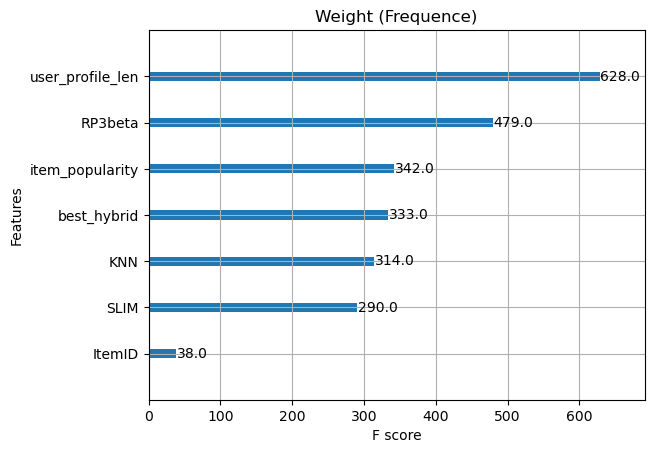

In [43]:
plot_importance(XGB_model_best, importance_type='weight', title='Weight (Frequence)')

In [44]:
xgb_res_df = pd.read_csv("result_experiments/XGBOST/optuna_res.csv")

In [45]:
xgb_res_df.sort_values("MAP", ascending=False)

,cutoff,n_estimators,learning_rate,reg_alpha,reg_lambda,max_depth,max_leaves,iteration,MAP
22,77,606,0.215894,33.243341,0.595330,5,5,22,0.063707
41,40,404,0.182938,32.456752,0.797607,5,4,41,0.063702
12,42,748,0.196914,48.202717,0.646220,4,7,12,0.063695
15,98,814,0.220815,49.162577,0.961005,5,4,15,0.063690
37,59,522,0.135629,39.394356,0.826591,4,5,37,0.063659
31,71,467,0.251854,33.412932,0.761527,7,3,31,0.063608
49,127,813,0.203631,45.086153,0.354760,4,9,49,0.063599
32,68,449,0.236068,41.430405,0.888459,8,2,32,0.063595
24,82,543,0.250226,33.562153,0.791072,7,3,24,0.063594
33,109,303,0.253278,23.189083,0.732479,6,5,33,0.063578


In [49]:
def objective(optuna_trial):
    cutoff = optuna_trial.suggest_int("cutoff", 10, 200)
    n_estimators = optuna_trial.suggest_int("n_estimators", 500, 1500)
    learning_rate =optuna_trial.suggest_float("learning_rate", 0.09, 0.5)
    reg_alpha = optuna_trial.suggest_float("reg_alpha", 30, 55)
    reg_lambda = optuna_trial.suggest_float("reg_lambda", 0.3, 0.9)
    max_depth = optuna_trial.suggest_int("max_depth", 3, 11)
    max_leaves = optuna_trial.suggest_int("max_leaves", 5, 15)
    grow_policy = "depthwise"
    objective = "pairwise"
    booster = "gbtree"
    random_seed = None

    training1_dataframe=create_dataframe_with_label(URM_train1, URM_train2, other_algorithms, cutoff)
    training_dataframe=create_dataframe_without_label(URM_train, other_algorithms_eval, cutoff)
    groups = training1_dataframe.groupby("UserID").size().values
    
    y_train1 = training1_dataframe["Label"]
    X_train1 = training1_dataframe.drop(columns=["Label"])

    X_train1["UserID"] = X_train1["UserID"].astype("category")
    X_train1["ItemID"] = X_train1["ItemID"].astype("category")

    training_dataframe["UserID"] = training_dataframe["UserID"].astype("category")
    training_dataframe["ItemID"] = training_dataframe["ItemID"].astype("category")
    
    XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

    XGB_model.fit(X_train1,
                y_train1,
                group=groups,
                verbose=True)
    
       
    return evaluate_algorithm_xgboost(URM_val, training_dataframe, XGB_model)

In [50]:
class SaveResults(object):
    def __init__(self, file_path=None):
        self.file_path = file_path
        self.results = []
    
    def __call__(self, optuna_study, optuna_trial):
        trial_result = optuna_trial.params.copy()
        trial_result["iteration"] = optuna_trial.number
        trial_result["MAP"] = optuna_trial.value
        
        self.results.append(trial_result)
        
        # Convert to DataFrame and save to CSV
        results_df = pd.DataFrame(self.results)
        results_df.to_csv(self.file_path, index=False)

In [51]:
study = op.create_study(direction="maximize")
save_results= SaveResults("result_experiments/XGBOST/optuna_res2.csv")
study.optimize(objective, callbacks=[save_results], n_trials=100)

[I 2025-01-03 20:18:38,172] A new study created in memory with name: no-name-07276208-169d-4d6c-8474-14b46bca8065
100%|████████████████████████████████████| 35736/35736 [00:46<00:00, 773.38it/s]
[I 2025-01-03 20:21:08,916] Trial 0 finished with value: 0.06288025578666154 and parameters: {'cutoff': 16, 'n_estimators': 858, 'learning_rate': 0.18089298385037728, 'reg_alpha': 33.90418360799869, 'reg_lambda': 0.30340030553714514, 'max_depth': 6, 'max_leaves': 11}. Best is trial 0 with value: 0.06288025578666154.
100%|████████████████████████████████████| 35736/35736 [01:59<00:00, 298.10it/s]
[I 2025-01-03 20:27:53,588] Trial 1 finished with value: 0.06317500645897078 and parameters: {'cutoff': 190, 'n_estimators': 1191, 'learning_rate': 0.4197675588337327, 'reg_alpha': 53.54889918590177, 'reg_lambda': 0.7368316758271956, 'max_depth': 9, 'max_leaves': 11}. Best is trial 1 with value: 0.06317500645897078.
100%|████████████████████████████████████| 35736/35736 [01:22<00:00, 431.83it/s]
[I 2025

KeyboardInterrupt: 

In [61]:
output_path = 'result_experiments/XGBOST/results.csv'
save_results.results_df.to_csv(output_path, sep=',', index=False)

In [80]:
study.best_params

{'cutoff': 77,
 'n_estimators': 606,
 'learning_rate': 0.2158940080664111,
 'reg_alpha': 33.243341201150095,
 'reg_lambda': 0.595330196145776,
 'max_depth': 5,
 'max_leaves': 5}

# TESTING

In [36]:
training_dataframe = create_dataframe_with_label(URM_train, URM_val, other_algorithms_eval, cutoff=cutoff)

In [37]:
SLIM_ElasticRecall_train_val_eval = SLIMElasticNetRecommender(URM_train+URM_val)
SLIM_ElasticRecall_train_val_eval.fit(topK= 296, l1_ratio=0.10442943478590742, alpha=0.00035921608889258387)
#SLIM_ElasticRecall_train_val_eval.load_model('result_experiments/SLIM/', 'slim_307_train_val_ens')

SLIMElasticNetRecommender: Processed 8435 (22.1%) in 5.00 min. Items per second: 28.11
SLIMElasticNetRecommender: Processed 16808 (44.1%) in 10.00 min. Items per second: 28.01
SLIMElasticNetRecommender: Processed 25230 (66.2%) in 15.00 min. Items per second: 28.03
SLIMElasticNetRecommender: Processed 33836 (88.8%) in 20.00 min. Items per second: 28.19
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 22.56 min. Items per second: 28.16


In [38]:
RP3BetaRecall_train_val_eval = RP3betaRecommender(URM_train+URM_val)
RP3BetaRecall_train_val_eval.fit(alpha=0.205870, beta=0.243986, topK=17, min_rating=0.0, implicit=False, normalize_similarity=True)

RP3betaRecommender: Similarity column 38121 (100.0%), 4188.14 column/sec. Elapsed time 9.10 sec


In [39]:
KNNRecall_train_val_eval = ItemKNNCFRecommender(URM_train+URM_val)
KNNRecall_train_val_eval.fit(similarity='tversky', topK=5, shrink=24.383723,
                   feature_weighting='none', tversky_alpha=0.405750,
                   tversky_beta=1.823707,
                   normalize=True)

Similarity column 38121 (100.0%), 4633.65 column/sec. Elapsed time 8.23 sec


In [40]:
SLIM_ElasticRecall_train_val_eval.save_model("result_experiments/SLIM/", "SLIM_ElasticRecall_train_val_eval")
RP3BetaRecall_train_val_eval.save_model("result_experiments/RP3beta/", "RP3BetaRecall_train_val_eval")
KNNRecall_train_val_eval.save_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_train_val_eval")

SLIMElasticNetRecommender: Saving model in file 'result_experiments/SLIM/SLIM_ElasticRecall_train_val_eval'
SLIMElasticNetRecommender: Saving complete
RP3betaRecommender: Saving model in file 'result_experiments/RP3beta/RP3BetaRecall_train_val_eval'
RP3betaRecommender: Saving complete
ItemKNNCFRecommender: Saving model in file 'result_experiments/ItemKNNCFRecommender/KNNRecall_train_val_eval'
ItemKNNCFRecommender: Saving complete


In [41]:
new_similarityRecall_train_val_eval = 0.862708291473966 * SLIM_ElasticRecall_train_val_eval.W_sparse + 0.10238146945917358 * RP3BetaRecall_train_val_eval.W_sparse + 0.034910239066860506 * KNNRecall_train_val_eval.W_sparse
candidate_gen_train_val_eval = ItemKNNCustomSimilarityRecommender(URM_train+URM_val)
candidate_gen_train_val_eval.fit(new_similarityRecall_train_val_eval)

In [42]:
SLIM_Elastic_train_val_eval = SLIMElasticNetRecommender(URM_train+URM_val)
SLIM_Elastic_train_val_eval.fit(topK=320, l1_ratio=0.1527515113685262, alpha=0.00022576119312621578)

RP3Beta_train_val_eval = RP3betaRecommender(URM_train+URM_val)
RP3Beta_train_val_eval.fit(alpha=0.4176290154380183, beta=0.21520987912346945, topK=19,
                    min_rating=0.0, implicit=False, normalize_similarity=True)

KNN_train_val_eval = ItemKNNCFRecommender(URM_train+URM_val)
KNN_train_val_eval.fit(similarity='tversky', 
                        topK = 6,
                        shrink= 21.589349496863413,
                        feature_weighting= 'TF-IDF',
                        normalize= False,
                        tversky_alpha= 0.16725184866550824,
                        tversky_beta= 1.722012798691049)

SLIMElasticNetRecommender: Processed 8043 (21.1%) in 5.00 min. Items per second: 26.80
SLIMElasticNetRecommender: Processed 16299 (42.8%) in 10.00 min. Items per second: 27.16
SLIMElasticNetRecommender: Processed 24768 (65.0%) in 15.00 min. Items per second: 27.52
SLIMElasticNetRecommender: Processed 33192 (87.1%) in 20.00 min. Items per second: 27.66
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 23.11 min. Items per second: 27.49
RP3betaRecommender: Similarity column 38121 (100.0%), 4132.52 column/sec. Elapsed time 9.22 sec
Similarity column 38121 (100.0%), 4654.53 column/sec. Elapsed time 8.19 sec


In [43]:
SLIM_Elastic_train_val_eval.save_model("result_experiments/SLIM/", "SLIM_Elastic_train_val_eval")
RP3Beta_train_val_eval.save_model("result_experiments/RP3beta/", "RP3Beta_train_val_eval")
KNN_train_val_eval.save_model("result_experiments/ItemKNNCFRecommender/", "KNN_train_val_eval")

SLIMElasticNetRecommender: Saving model in file 'result_experiments/SLIM/SLIM_Elastic_train_val_eval'
SLIMElasticNetRecommender: Saving complete
RP3betaRecommender: Saving model in file 'result_experiments/RP3beta/RP3Beta_train_val_eval'
RP3betaRecommender: Saving complete
ItemKNNCFRecommender: Saving model in file 'result_experiments/ItemKNNCFRecommender/KNN_train_val_eval'
ItemKNNCFRecommender: Saving complete


In [44]:
best_similarity_train_val_eval = 0.862708291473966 * SLIM_Elastic_train_val_eval.W_sparse + 0.10238146945917358 * RP3Beta_train_val_eval.W_sparse + 0.034910239066860506 * KNN_train_val_eval.W_sparse
best_hybrid_train_val_eval = ItemKNNCustomSimilarityRecommender(URM_train+URM_val)
best_hybrid_train_val_eval.fit(best_similarity_train_val_eval)

In [45]:
other_algorithms_train_val_eval = {
    "RP3beta": RP3Beta_train_val_eval,
    "SLIM": SLIM_Elastic_train_val_eval,
    "KNN": KNN_train_val_eval,
    "best_hybrid": best_hybrid_train_val_eval,
    # "SLIM_bpr":SLIM_bpr,
    # "P3a":P3a,
    "candidate_generator": candidate_gen_train_val_eval
}

In [47]:
test_dataframe=create_dataframe_without_label(URM_train+URM_val, other_algorithms_train_val_eval, cutoff=cutoff)

In [49]:
y_train= training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

test_dataframe["UserID"] = test_dataframe["UserID"].astype("category")
test_dataframe["ItemID"] = test_dataframe["ItemID"].astype("category")

In [50]:
groups = training_dataframe.groupby("UserID").size().values

In [51]:
#AS A REFERENCE,CURRENT BEST
n_estimators = 606
learning_rate = 0.2158940080664111
reg_alpha = 33.243341201150095
reg_lambda = 0.595330196145776
max_depth = 5
max_leaves = 5
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
random_seed = None

XGB_model_test_best = XGBRanker(objective='rank:{}'.format(objective),
                  n_estimators = int(n_estimators),
                  random_state = random_seed,
                  learning_rate = learning_rate,
                  reg_alpha = reg_alpha,
                  reg_lambda = reg_lambda,
                  max_depth = int(max_depth),
                  max_leaves = int(max_leaves),
                  grow_policy = grow_policy,
                  verbosity = 0, # 2 if self.verbose else 0,
                  booster = booster,
                  enable_categorical = True,
                  tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                  )

XGB_model_test_best.fit(X_train,
            y_train,
            group=groups,
            verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.2158940080664111,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=5, max_leaves=5, min_child_weight=None,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=606, n_jobs=None, num_parallel_tree=None,
          objective='rank:pairwise', ...)

In [52]:
print(evaluate_algorithm_xgboost(URM_test, test_dataframe, XGB_model_test_best))

100%|████████████████████████████████████| 35736/35736 [01:05<00:00, 545.98it/s]

0.08355724999229268


In [53]:
evaluate_algorithm(URM_test, best_hybrid_train_val_eval), evaluate_algorithm(URM_test, SLIM_Elastic_train_val_eval), evaluate_algorithm(URM_test, RP3Beta_train_val_eval), evaluate_algorithm(URM_test, KNN_train_val_eval)

(0.08402817565563181,
 0.0837216876601205,
 0.07551240567510359,
 0.0747781539320609)

In [79]:
groups

array([330, 330, 330, ..., 330, 330, 330])

In [80]:
study.best_params

{'cutoff': 330,
 'n_estimators': 337,
 'learning_rate': 0.010444729746988764,
 'reg_alpha': 46.678022346382555,
 'reg_lambda': 0.30629160267515565,
 'max_depth': 4,
 'max_leaves': 6}